In [43]:
import sys
import os
path_father = os.path.abspath(r'..')
path_father
# sys.path.append(path_father)

'/home/egbert_jing/github/NEKG_G/Final_project'

this program only uses word2vec embedding method, which serves as a baseline

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
%matplotlib inline

In [45]:
df = pd.read_csv(path_father + "/df_with_gcs.txt",sep=',',header=0)

In [46]:
#划分训练测试集
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.1, random_state=42)

处理词向量

In [47]:
from gensim.models import word2vec
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) 

In [48]:
# 切分词汇
def cut(data):
    cut= [s.split() for s in data['TriageNote'].astype(str)]
    return cut

In [49]:
train_text=cut(train_set)
test_text=cut(test_set)
sentences=train_text+test_text

In [50]:
#得到最大句子长度
num_list=[len(one) for one in sentences]
max(num_list)

57

In [51]:
maxLen=64

In [52]:
#处理label->one_hot
from sklearn.preprocessing import LabelEncoder

def encodelabel(data):
    le = LabelEncoder()
    resultLable=le.fit_transform(data['DISPOSITION'])
    return resultLable


In [53]:
train_lable=encodelabel(train_set)
test_lable=encodelabel(test_set)

In [54]:
wvmodel = word2vec.Word2Vec.load("./word2vec_all.model")

2022-11-10 23:27:34,181 : INFO : loading Word2Vec object from ./word2vec_all.model
2022-11-10 23:27:34,211 : INFO : loading wv recursively from ./word2vec_all.model.wv.* with mmap=None
2022-11-10 23:27:34,212 : INFO : setting ignored attribute cum_table to None
2022-11-10 23:27:34,420 : INFO : Word2Vec lifecycle event {'fname': './word2vec_all.model', 'datetime': '2022-11-10T23:27:34.420175', 'gensim': '4.2.0', 'python': '3.10.6 (main, Oct 24 2022, 16:07:47) [GCC 11.2.0]', 'platform': 'Linux-5.15.68.1-microsoft-standard-WSL2-x86_64-with-glibc2.35', 'event': 'loaded'}


In [55]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(sentences)
vocab = tokenizer.word_index 

In [56]:
#特征数字编号，不足的话会在前面补充0
trainID = tokenizer.texts_to_sequences(train_text)
# print(trainID)
testID = tokenizer.texts_to_sequences(test_text)
trainSeq=pad_sequences(trainID,maxlen=maxLen)
#print(trainSeq)
testSeq=pad_sequences(testID,maxlen=maxLen)

#标签的独热编码
trainCate = to_categorical(train_lable, num_classes=2)  # 将标签转换为one-hot编码
#print(trainCate)
testCate= to_categorical(test_lable, num_classes=2)  # 将标签转换为one-hot编码

embedding_matrix = np.zeros((len(vocab) + 1, 100))
for word, i in vocab.items():
    try:
        embedding_vector = wvmodel.wv[str(word)]
        embedding_matrix[i] = embedding_vector    
    except KeyError:
        continue

In [57]:
#利用训练后的word2vec自定义Embedding的训练矩阵，每行代表一个词（结合独热码和矩阵乘法理解）
embedding_matrix = np.zeros((len(vocab) + 1, 100))
for word, i in vocab.items():
    try:
        if(word.isdigit()==False):#对word用word2vec
            embedding_vector = wvmodel.wv[str(word)]
        embedding_matrix[i] = embedding_vector    
    except KeyError:
        continue

In [58]:
## 定义LSTM模型
batch_size = 32
inputs = Input(name='inputs',shape=[maxLen])
embedder = Embedding(len(vocab) + 1, 100, input_length=maxLen, weights=[embedding_matrix], trainable=True)
model=Sequential()
model.add(embedder)
model.add(LSTM(64))
model.add(Dropout(0.4))
model.add(Dense(64,activation="softmax",name="FC1"))
model.add(Dropout(0.4))
model.add(Dense(2,activation="softmax",name="FC2"))
model.summary()
model.compile(loss="categorical_crossentropy",optimizer=RMSprop(),metrics=["accuracy"])
#reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1 ,patience=3, mode='auto')
history=model.fit(trainSeq, trainCate, batch_size, epochs=15,validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',patience=2)])
model.save("LSTM")

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 64, 100)           806300    
                                                                 
 lstm_15 (LSTM)              (None, 64)                42240     
                                                                 
 dropout_30 (Dropout)        (None, 64)                0         
                                                                 
 FC1 (Dense)                 (None, 64)                4160      
                                                                 
 dropout_31 (Dropout)        (None, 64)                0         
                                                                 
 FC2 (Dense)                 (None, 2)                 130       
                                                                 
Total params: 852,830
Trainable params: 852,830
Non-t

2022-11-10 23:28:20,813 : WARNING : Found untraced functions such as lstm_cell_17_layer_call_fn, lstm_cell_17_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: LSTM/assets


2022-11-10 23:28:21,874 : INFO : Assets written to: LSTM/assets


In [59]:
#预测与评估
mainModel = load_model('LSTM')
result = mainModel.predict(testSeq)  # 预测样本属于每个类别的概率
score = mainModel.evaluate(testSeq,
                           testCate,
                           batch_size=32)
print(score)

6/6 [==============================] - 1s 18ms/step - loss: 0.6327 - accuracy: 0.6725
[0.6326813697814941, 0.6725146174430847]


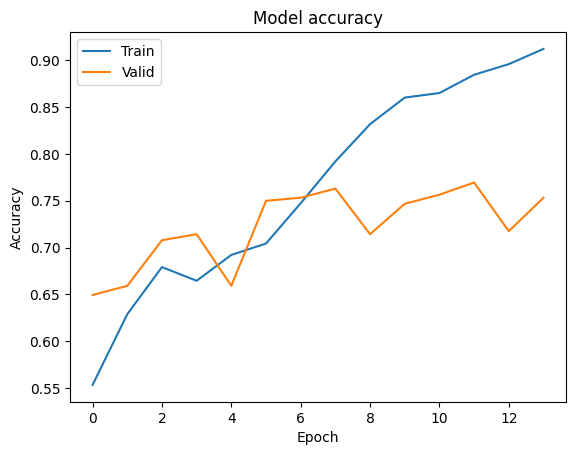

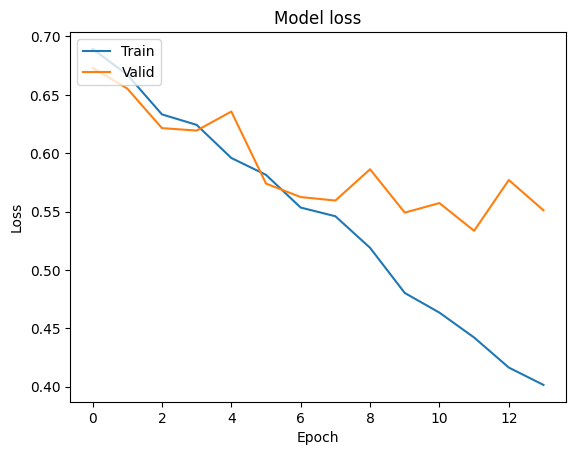

In [60]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Valid'],loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Valid'],loc='upper left')
plt.show()

In [61]:
score_list=[]
for i in range(10):
    ## 定义LSTM模型
    batch_size = 32
    inputs = Input(name='inputs',shape=[maxLen])
    embedder = Embedding(len(vocab) + 1, 100, input_length=maxLen, weights=[embedding_matrix], trainable=True)
    model=Sequential()
    model.add(embedder)
    model.add(LSTM(64))
    model.add(Dropout(0.4,seed=12))
    model.add(Dense(64,activation="softmax",name="FC1"))
    model.add(Dropout(0.4,seed=12))
    model.add(Dense(2,activation="softmax",name="FC2"))
    model.summary()
    model.compile(loss="categorical_crossentropy",optimizer=RMSprop(),metrics=["accuracy"])
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1 ,patience=3, mode='auto')
    history=model.fit(trainSeq, trainCate, batch_size, epochs=15,validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',patience=2)])
    result = model.predict(testSeq)  # 预测样本属于每个类别的概率
    score = model.evaluate(testSeq,
                               testCate,
                               batch_size=32)
    score_list.append(score[1])

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 64, 100)           806300    
                                                                 
 lstm_16 (LSTM)              (None, 64)                42240     
                                                                 
 dropout_32 (Dropout)        (None, 64)                0         
                                                                 
 FC1 (Dense)                 (None, 64)                4160      
                                                                 
 dropout_33 (Dropout)        (None, 64)                0         
                                                                 
 FC2 (Dense)                 (None, 2)                 130       
                                                                 
Total params: 852,830
Trainable params: 852,830
Non-t

In [62]:
print('accuracy:'+str(sum(score_list)/len(score_list)))

accuracy:0.6690058529376983


In [63]:
score_list.sort()

In [64]:
score_list

[0.6081871390342712,
 0.6198830604553223,
 0.6198830604553223,
 0.6491228342056274,
 0.6549707651138306,
 0.6783625483512878,
 0.6900584697723389,
 0.7134503126144409,
 0.7251461744308472,
 0.7309941649436951]

In [65]:
sum(score_list[1:])/len(score_list[1:])

0.6757634878158569